<a href="https://colab.research.google.com/github/d-elicio/Music-Recommender-System-from-scratch/blob/main/Music_Recommender_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
from numpy import count_nonzero
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.linalg import svds
import sys
import itertools
import altair as alt
import warnings
warnings.filterwarnings("ignore")

from google.colab import data_table
data_table.enable_dataframe_formatter()
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LOAD DATASET

**MILLION SONG DATASET USED SUBSETS:**

* **Echo Nest Taste Profile subset**     (*user_id*, *track_id*, *title*, *artist*,  *listen_count*)

* **Last.fm subset** (*track_id*, *genre*)

In [ ]:
filepath1 = '/content/drive/MyDrive/music recommender project datasets/complete_song_dataset2'
filepath2 = "/content/drive/MyDrive/music recommender project datasets/tracks_with_genre1.txt"
filepath3 = "/content/drive/MyDrive/music recommender project datasets/tracks_with_genre2.txt"
filepath4 = "/content/drive/MyDrive/music recommender project datasets/tracks_with_genre3.txt"

def load_dataset(filepath1, filepath2, filepath3, filepath4):
  #Load the Echo Nest Taste Profile subset
  song_df = pd.read_csv(filepath1, dtype={"listen_count": int, "artist": "string", "title": "string"})
  song_df['title_artist'] = song_df['title'] + " - " + song_df['artist']
  song_df.head()

  #Load the Last.fm subset
  song_genre1 = pd.read_csv(filepath2, sep='\t', header=None)
  song_genre1.columns = ['track_id','genre']
  
  song_genre2 = pd.read_csv(filepath3, sep='\t', header=None)
  song_genre2.columns = ['track_id','genre']

  song_genre3 = pd.read_csv(filepath4, sep='\t', header=None)
  song_genre3.columns = ['track_id','genre']

  #Merge the two subsets to create the final dataset to use:
  tmp1 = pd.concat([song_genre1,song_genre2])
  tmp1 = tmp1[~tmp1.index.duplicated(keep='first')]

  tmp2 = pd.concat([tmp1,song_genre3])
  tmp2 = tmp2[~tmp2.index.duplicated(keep='first')]
  tmp2 = tmp2.dropna(how='any',axis=0)

  song_and_genre_df = song_df.merge(tmp2, on=['track_id'], how='inner')
  song_and_genre_df = song_and_genre_df[['user_id','track_id','title','artist','title_artist','genre','listen_count']]
  song_and_genre_df.drop_duplicates(inplace=True)

  #Show the dataset that will be used:
  display(song_and_genre_df)
  print(f'Initial complete dataset shape: {song_and_genre_df.shape}')
  return song_and_genre_df

In [ ]:
song_and_genre_df = load_dataset(filepath1, filepath2, filepath3, filepath4)

,user_id,track_id,title,artist,title_artist,genre,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,TRWECMU128F1459198,Dala,Ayub Ogada,Dala - Ayub Ogada,International,1
1,8c3b4af3e61193518ea99556370100dde98bbeab,TRWECMU128F1459198,Dala,Ayub Ogada,Dala - Ayub Ogada,International,7
2,b629e3b3db7a432151f6ba2189e87adc595561af,TRWECMU128F1459198,Dala,Ayub Ogada,Dala - Ayub Ogada,International,1
3,1c42d0656661832a302e81772eeef5fa6f4642f6,TRWECMU128F1459198,Dala,Ayub Ogada,Dala - Ayub Ogada,International,1
4,cff4c141907ede811ee376c1b8b5d72e3a070875,TRWECMU128F1459198,Dala,Ayub Ogada,Dala - Ayub Ogada,International,1
...,...,...,...,...,...,...,...
1215006,0b5bc09dbe2c680b2da377ca0db3f81fb961175c,TRMQRSV128F1472F8E,Tuff Tuff Tuff (Som Ett Lokomotiv) (2004 Digit...,Gyllene Tider,Tuff Tuff Tuff (Som Ett Lokomotiv) (2004 Digit...,Pop_Rock,1
1215007,104bcda48463a99997f668b897c32234793cd514,TRWWEBI128F9304320,Boyz,Lex Empress,Boyz - Lex Empress,Electronic,1
1215008,4d6878f1eae4651b37b52c0d1b9a89e331922fd7,TRWFDMV128F930BD79,Crucifunkin' (Album Version),Gruntruck,Crucifunkin' (Album Version) - Gruntruck,Pop_Rock,1
1215009,d8b6fff0c9fb25a42949c4136a6ce69949423cef,TRMGIIB128F425CE5C,Initial Distrust,Total Chaos,Initial Distrust - Total Chaos,Pop_Rock,1


Initial complete dataset shape: (1215011, 7)


# EXPLORATIVE DATA ANALYSIS

In [ ]:
print(f"Dataset's shape: {song_and_genre_df.shape}\n")
print(f"\tNumber of unique USERS: {song_and_genre_df['user_id'].nunique():,} \t\t Number of NULL user_id values: {song_and_genre_df['user_id'].isna().sum()}".replace(',', '.'))
print(f"\tNumber of unique SONGS: {song_and_genre_df['title'].nunique():,} \t\t\t Number of NULL title values: {song_and_genre_df['title'].isna().sum()}".replace(',', '.'))
print(f"\tNumber of unique ARTISTS: {song_and_genre_df['artist'].nunique():,} \t\t Number of NULL artist values: {song_and_genre_df['artist'].isna().sum()}".replace(',', '.'))
print(f"\tNumber of unique LISTENING VALUES: {song_and_genre_df['listen_count'].nunique()} \t\t Number of NULL listen_count values: {song_and_genre_df['listen_count'].isna().sum()}\n")
print(f"\tMAX no. of times a single song has been listened by a single user: {song_and_genre_df['listen_count'].max():,}".replace(',', '.'))
print(f"\tMIN no. of times a single song has been listened by a single user: {song_and_genre_df['listen_count'].min():,}".replace(',', '.'))

Dataset's shape: (1215011, 7)

	Number of unique USERS: 530.559 		 Number of NULL user_id values: 0
	Number of unique SONGS: 8.152 			 Number of NULL title values: 0
	Number of unique ARTISTS: 5.095 		 Number of NULL artist values: 0
	Number of unique LISTENING VALUES: 259 		 Number of NULL listen_count values: 0

	MAX no. of times a single song has been listened by a single user: 784
	MIN no. of times a single song has been listened by a single user: 1


In [ ]:
# TOTAL LISTENINGS made by every the users (how much plays a single user have)
total_users_listenings = song_and_genre_df.groupby('user_id')['listen_count'].sum().to_frame(name='total_listenings')
total_users_listenings.sort_values(by='total_listenings', ascending=False, inplace=True)
total_users_listenings.reset_index(inplace=True)
# display(total_users_listenings)

# # UNIQUE SONGS PER USER (how many unique songs a user have listened)
unique_songs_per_user = song_and_genre_df.groupby('user_id')['title'].count().reset_index().sort_values(by='title', ascending=False)
unique_songs_per_user.rename(columns={'title':'unique_songs_listened'}, inplace=True)
# # display(unique_songs_per_user)


				MAX no. of times a single song has been listened by a single user: 831
				MAX no. of different songs listened by a single user: 128



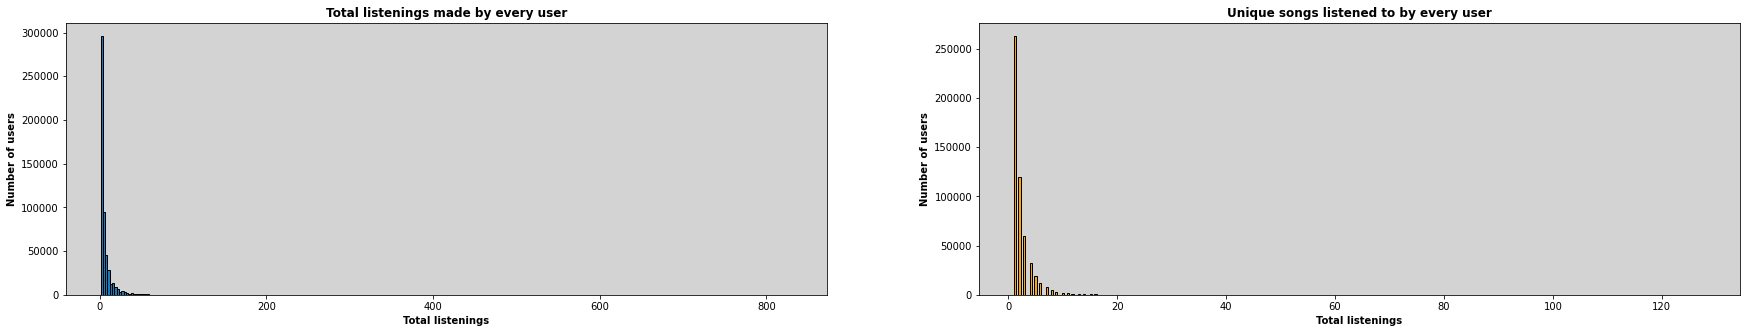

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(30,5))
ax1.hist(total_users_listenings.total_listenings, bins=300, edgecolor="black")
ax1.set_title('Total listenings made by every user', fontweight='bold')
ax1.set_xlabel("Total listenings", fontweight='bold')
ax1.set_ylabel("Number of users", fontweight='bold')
ax1.set_facecolor("lightgray")

ax2.hist(unique_songs_per_user.unique_songs_listened, bins=300, edgecolor="black", color="orange")
ax2.set_title('Unique songs listened to by every user', fontweight='bold')
ax2.set_xlabel("Total listenings", fontweight='bold')
ax2.set_ylabel("Number of users", fontweight='bold')
ax2.set_facecolor("lightgray")

print(f"\n\t\t\t\tMAX no. of times a single song has been listened by a single user: {total_users_listenings['total_listenings'].max():,}".replace(',', '.'))
print(f"\t\t\t\tMAX no. of different songs listened by a single user: {unique_songs_per_user['unique_songs_listened'].max():,}\n".replace(',', '.'))

In [ ]:
# 95esimo percentile = se prendi 100 utenti 95 hanno meno di 22 ascolti 
print("\nPercentiles quantities of total listen_counts listened by every user:")
display(total_users_listenings.quantile([.25, .5, .75, .95]))
print("\nPercentiles quantities of unique songs listened by every user:")
display(unique_songs_per_user.quantile([.25, .5, .75, .97]))


Percentiles quantities of total listen_counts listened by every user:


,total_listenings
0.25,1.0
0.50,3.0
0.75,7.0
0.95,22.0



Percentiles quantities of unique songs listened by every user:


,unique_songs_listened
0.25,1.0
0.50,2.0
0.75,3.0
0.97,8.0


# Dataset modification (to consider only users with a certain number of songs listened)

In [ ]:
temp = song_and_genre_df.copy()
temp = temp.groupby('user_id').agg({'listen_count':'sum', 'title':'count'}).rename(columns={'listen_count':'totalPlays', 'title':'uniqueSongs'}).reset_index() 

#Filter the original dataset to consider only users with a total listen_count >= 48 listenings and a number of unique songs listened to >= 21 songs:
filter1 = temp[['user_id','totalPlays']].loc[temp['totalPlays'] >= 48]
filter2 = temp[['user_id','uniqueSongs']].loc[temp['uniqueSongs'] >= 21]
filter3 = temp.loc[(temp['totalPlays'] >= 48) & (temp['uniqueSongs'] >= 21)]

filter3_list = filter3.user_id.tolist()
print(f'\nFinal number of users in the filtered dataset (that will be used to create all the recommendations methods): {len(filter3_list)}')

final_df = song_and_genre_df.loc[song_and_genre_df['user_id'].isin(filter3_list)]
# display(final_df)


Final number of users in the filtered dataset (that will be used to create all the recommendations methods): 198


In [ ]:
#Compute listening frequency for every user:
#Get the total listen count for each user_id:
temp = final_df.copy()
temp['total_listen_count_per_user'] = temp.groupby('user_id')['listen_count'].transform('sum')

#Compute the song frequency by dividing the sum of song_listen_counts per song by the total_listen_count for each user:
temp = temp[['user_id','total_listen_count_per_user']]
listen_count_by_user_dicitionary = temp.set_index('user_id')['total_listen_count_per_user'].to_dict()
final_df['song_frequency_per_user']= final_df['listen_count']/temp['total_listen_count_per_user']

#Show the data:
display(final_df.head())

,user_id,track_id,title,artist,title_artist,genre,listen_count,song_frequency_per_user
1262,ab792cde4fb868b3cf232791f173f7fd5e2ee83d,TRMSZXT128F92F7816,Love Song For No One,John Mayer,Love Song For No One - John Mayer,Pop_Rock,3,0.044776
1680,738759001498928d8dcb054cd53a1a0cfc200d36,TRMSZXT128F92F7816,Love Song For No One,John Mayer,Love Song For No One - John Mayer,Pop_Rock,2,0.028986
2394,974a05be3d2385f40af4e6e610be59544657085e,TRMSZXT128F92F7816,Love Song For No One,John Mayer,Love Song For No One - John Mayer,Pop_Rock,5,0.056180
2503,a771391d088269c5dc7adcc9e7e0e77d3cf8b80b,TRMSZXT128F92F7816,Love Song For No One,John Mayer,Love Song For No One - John Mayer,Pop_Rock,3,0.061224
2613,b82d692dde839cfe9fd6d309bb8c46d50089cc16,TRMSZXT128F92F7816,Love Song For No One,John Mayer,Love Song For No One - John Mayer,Pop_Rock,2,0.020833


# Normalize frequency in a [1,5] interval like they were explicit ratings

In [ ]:
min_val = final_df['song_frequency_per_user'].min()
max_val = final_df['song_frequency_per_user'].max()

# Per la formula vedi qua: https://stats.stackexchange.com/a/281165/357782
final_df['rating'] = ((5-1)*((final_df['song_frequency_per_user'] - min_val) / (max_val - min_val))) + 1

In [ ]:
#Round all values to be included in a range 1-5 (values like 1.5, 2.5.. are accepted)
def custom_round(x, base=5):
    return base * round(float(x)/base)

final_df['rating'] = final_df['rating'].apply(lambda x: custom_round(x, base=.5))
final_df = final_df[['user_id','title','artist','title_artist','genre','listen_count','rating']]
display(final_df.head())

,user_id,title,artist,title_artist,genre,listen_count,rating
1262,ab792cde4fb868b3cf232791f173f7fd5e2ee83d,Love Song For No One,John Mayer,Love Song For No One - John Mayer,Pop_Rock,3,1.5
1680,738759001498928d8dcb054cd53a1a0cfc200d36,Love Song For No One,John Mayer,Love Song For No One - John Mayer,Pop_Rock,2,1.0
2394,974a05be3d2385f40af4e6e610be59544657085e,Love Song For No One,John Mayer,Love Song For No One - John Mayer,Pop_Rock,5,1.5
2503,a771391d088269c5dc7adcc9e7e0e77d3cf8b80b,Love Song For No One,John Mayer,Love Song For No One - John Mayer,Pop_Rock,3,1.5
2613,b82d692dde839cfe9fd6d309bb8c46d50089cc16,Love Song For No One,John Mayer,Love Song For No One - John Mayer,Pop_Rock,2,1.0



Ratings distribution in the dataset:


,rating,total
0,1.0,4206
1,1.5,1184
2,2.0,161
3,2.5,42
4,3.0,27
5,3.5,14
6,4.0,2
7,4.5,2
8,5.0,2


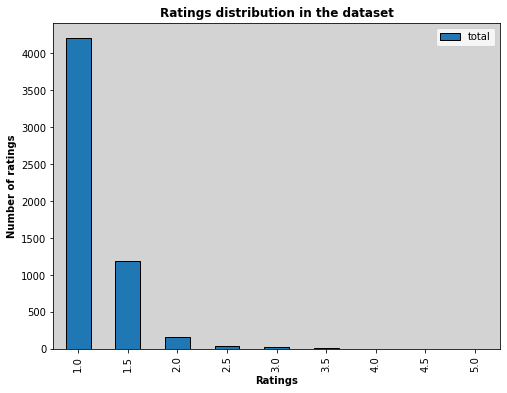

In [ ]:
#Plot distribution of ratings stored in the dataset: 
rating_count = final_df.groupby('rating')['user_id'].count().reset_index().rename(columns={'user_id':'total'})
print("\nRatings distribution in the dataset:")
display(rating_count)
print("")

ax = rating_count.plot(x="rating", y="total", kind="bar", edgecolor="black", figsize=(8,6))
ax.set_title('Ratings distribution in the dataset', fontweight='bold')
ax.set_xlabel("Ratings", fontweight='bold')
ax.set_ylabel("Number of ratings", fontweight='bold')
ax.set_facecolor("lightgray")

# Show most popular songs and artists:

,tot_plays
title_artist,
You've Got The Love - Florence + The Machine,193
Rabbit Heart (Raise It Up) - Florence + The Machine,160
The Maestro - Beastie Boys,146
The Absence Of God (Album Version) - Rilo Kiley,95
Elevator - The Black Keys,92
Here Without You - 3 Doors Down,91
Refuse / Resist - Apocalyptica,91
Never There - Cake,83
Van Helsing Boombox - Man Man,82


,tot_plays
artist,
Florence + The Machine,378
The Black Keys,245
Amy Winehouse,163
Beastie Boys,148
Muse,144
Rihanna,142
Thrice,135
Jack Johnson,127
Cake,127


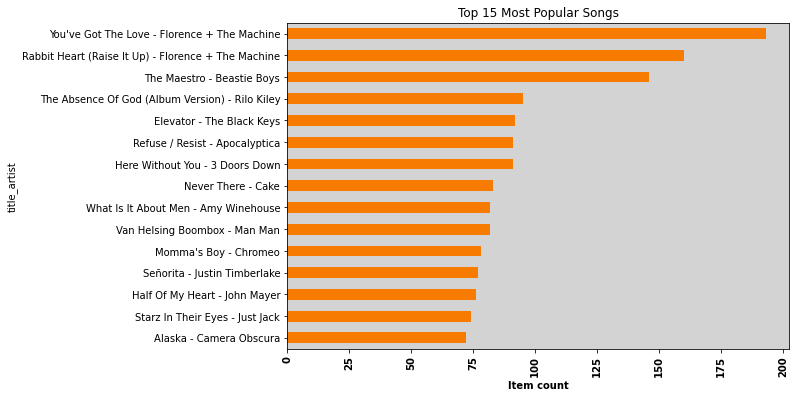

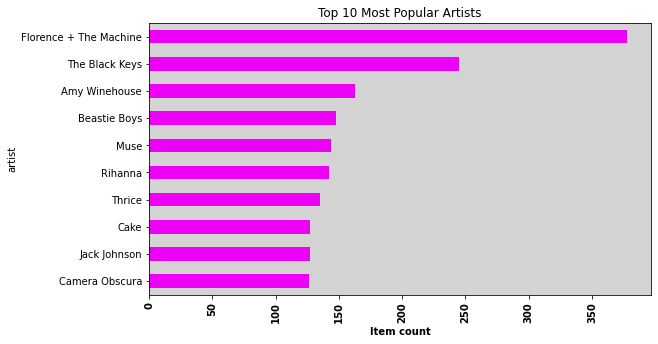

In [ ]:
# Dataframe with the top15 popular songs:
pop_songs = final_df[['title_artist','listen_count']].groupby('title_artist').sum().sort_values(by='listen_count', ascending=False).head(15).sort_values('listen_count')
pop_songs.rename(columns={'listen_count':'tot_plays'}, inplace=True)
display(pop_songs.sort_values('tot_plays', ascending=False).head(15))

# Dataframe with the top10 popular artists:
pop_artist = final_df[['artist','listen_count']].groupby('artist').sum().sort_values(by='listen_count', ascending=False).head(10).sort_values('listen_count')
pop_artist.rename(columns={'listen_count':'tot_plays'}, inplace=True)
display(pop_artist.sort_values('tot_plays', ascending=False).head(10))



# Plot the top15 MOST POPULAR SONGS:
ax1 = pop_songs.plot(kind='barh', title='Top 15 Most Popular Songs', legend=False, label='index', color='#F67B00', stacked=True, figsize=(9, 6))
plt.xticks(rotation='vertical', fontweight='bold')
plt.xlabel('Item count', fontweight='bold')
ax1.set_facecolor("lightgray")

# Plot the top15 MOST POPULAR ARTISTS:
ax2 = pop_artist.plot(kind='barh', title='Top 10 Most Popular Artists', legend=False, label='index', color='#EC00F6', stacked=True, figsize=(9, 5))
plt.xticks(rotation='vertical', fontweight='bold')
plt.xlabel('Item count', fontweight='bold')
ax2.set_facecolor("lightgray")

# Compute User-Items matrix sparsity and visualize it

If **X** is the User-Item matrix, the sparsity will be computed as follows:

<center>
$sparsity = 1 - \frac{no.\  of \ non \ zero \ elements \ of \ X}{total \ elements \ of \ X}$
</center>


The User-Items matrix has sparsity: 0.9844707997000574



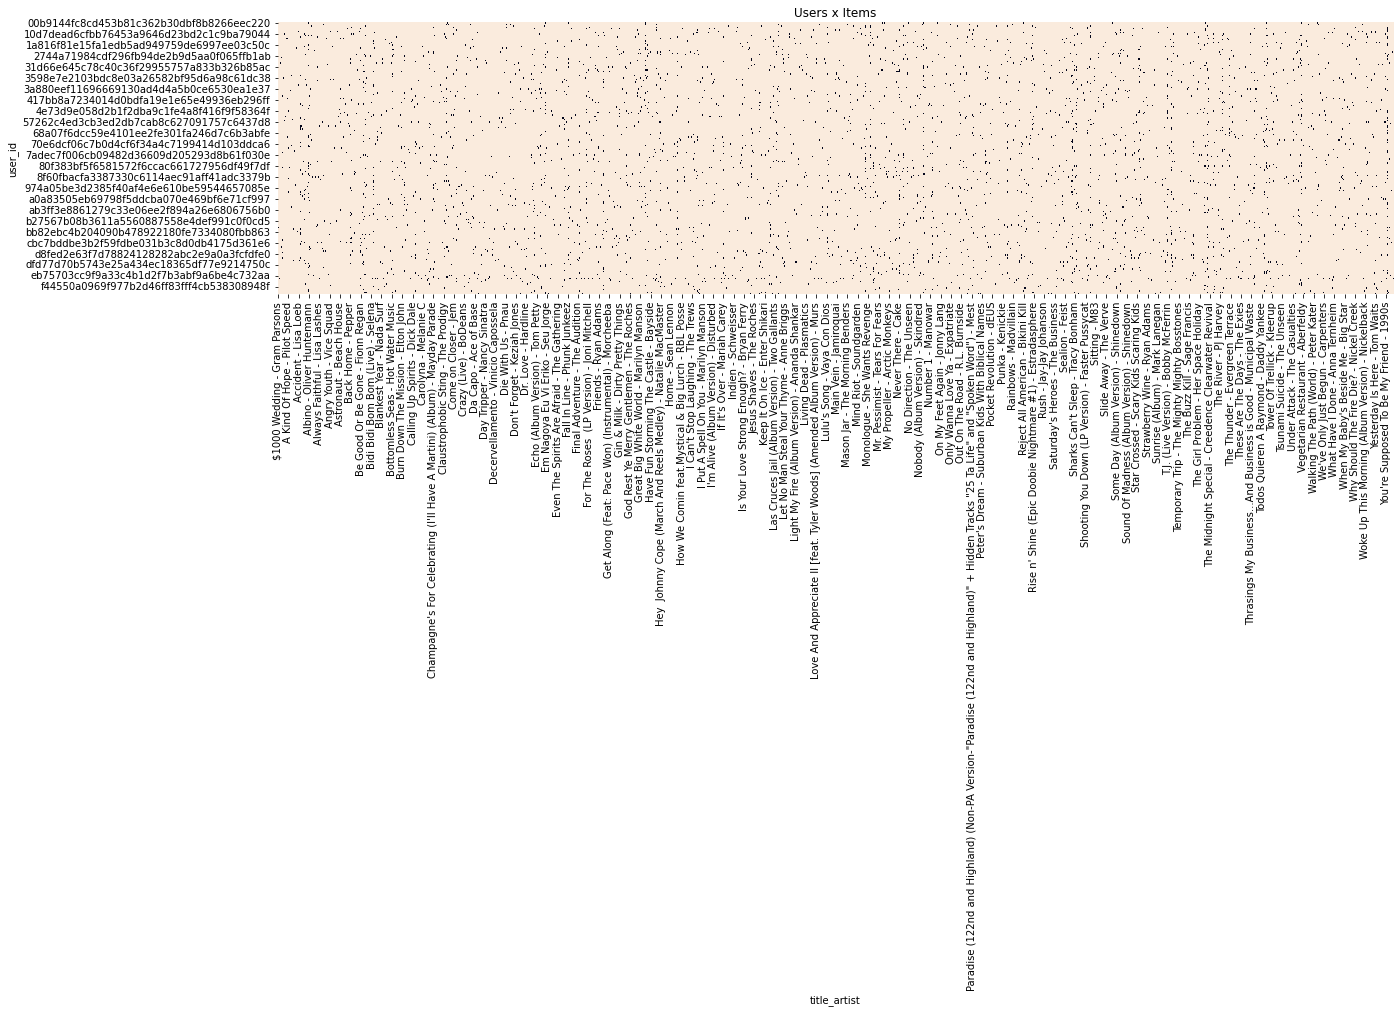

In [ ]:
# Show the sparsity of our user-item matrix:
tmp = final_df.copy()
user_item_table = tmp.pivot_table(index='user_id', columns='title_artist', values='rating', fill_value=0)

user_item_table.values
sparsity = 1.0 - ( count_nonzero(user_item_table) / float(user_item_table.size) )
print(f"\nThe User-Items matrix has sparsity: {sparsity}\n")

fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(user_item_table==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title("Users x Items")
plt.show()

# TRAIN/TEST SPLIT

In [ ]:
train, test = train_test_split(final_df, stratify=final_df['user_id'], test_size=0.3, random_state=50)

print(f'Train set shape: {train.shape}')
print(f'Test set shape: {test.shape}')


print(f"\tNumber of unique USERS: {train['user_id'].nunique():,} \t\t Number of NULL user_id values: {train['user_id'].isna().sum()}".replace(',', '.'))
print(f"\tNumber of unique SONGS: {train['title'].nunique():,} \t\t\t Number of NULL title values: {train['title'].isna().sum()}".replace(',', '.'))
print(f"\tNumber of unique ARTISTS: {train['artist'].nunique():,} \t\t Number of NULL artist values: {train['artist'].isna().sum()}".replace(',', '.'))
print(f"\tNumber of unique TITLE_ARTISTS: {train['title_artist'].nunique():,} \t\t Number of NULL title_artist values: {train['title_artist'].isna().sum()}\n".replace(',', '.'))

print("   ----TEST SET----")
print(f"\tNumber of unique USERS: {test['user_id'].nunique():,} \t\t Number of NULL user_id values: {test['user_id'].isna().sum()}".replace(',', '.'))
print(f"\tNumber of unique SONGS: {test['title'].nunique():,} \t\t\t Number of NULL title values: {test['title'].isna().sum()}".replace(',', '.'))
print(f"\tNumber of unique ARTISTS: {test['artist'].nunique():,} \t\t Number of NULL artist values: {test['artist'].isna().sum()}".replace(',', '.'))
print(f"\tNumber of unique TITLE_ARTISTS: {test['title_artist'].nunique():,} \t\t Number of NULL title_artist values: {test['title_artist'].isna().sum()}\n".replace(',', '.'))

Train set shape: (3948, 7)
Test set shape: (1692, 7)
	Number of unique USERS: 198 		 Number of NULL user_id values: 0
	Number of unique SONGS: 1.515 			 Number of NULL title values: 0
	Number of unique ARTISTS: 1.035 		 Number of NULL artist values: 0
	Number of unique TITLE_ARTISTS: 1.526 		 Number of NULL title_artist values: 0

   ----TEST SET----
	Number of unique USERS: 198 		 Number of NULL user_id values: 0
	Number of unique SONGS: 918 			 Number of NULL title values: 0
	Number of unique ARTISTS: 687 		 Number of NULL artist values: 0
	Number of unique TITLE_ARTISTS: 921 		 Number of NULL title_artist values: 0



# EVALUATION METHODS

**RMSE:** shows how far predictions fall from measured true values using Euclidean distance.
<center>
$RMSE = \sqrt{\frac{1}{N}\sum\limits_{i=1}^N(\hat{y_i} -y_i)^2} $
</center>
<br/>

**Precision:** a measure of *exactness*, determines the fraction of relevant items retrieved, out of all items retrieved (**how many items in the top-n list are relevant**) 

<center>E.g.: the proportion of recommended songs that are actually good <br/>
$precision = \frac{t_p}{t_p+f_p} = \frac{|good \ songs \ recommended|}{|all \ recommendations|}$
</center>

<br/>

**Recall:** a measure of *completeness*,  determines the fraction of relevant
items retrieved out of all relevant items (**how many of the relevant items actually made it into the top-n list**)

<center>
E.g. the proportion of all good songs recommended <br/>
$recall = \frac{t_p}{t_p+f_n} = \frac{|good \ songs \ recommended|}{|all \ good \ songs|}$
</center>

<br/>

**F1-score:** armonic mean of Precision and Recall
<center>
$F1 = 2 \cdot \frac{precision \cdot recall}{precision + recall}$

In [ ]:
class evaluation_methods:

  def rmse_computation(self, y_actual, y_predicted):
    rms = mean_squared_error(y_actual, y_predicted, squared=False)
    print(f"\n RMSE value: {rms}\n")
    return rms

  def prec_recall_f1_computation(self, test, all_users_scores, users_list, popularity_rec=False):
      rating_treshold = [1, 1.5, 2]
      number_of_recommendations = [5, 10, 15, 20, 30, 50]

      if popularity_rec == False:
        for tresh in rating_treshold:
          evaluation_dict = {'num_recommendations': [], 'precision@k': [], 'recall@k':[], 'f1-score@k':[]}
          all_users_scores_filtered = all_users_scores.loc[all_users_scores.predicted_rating>=tresh]
          print(f'RATING TRESHOLD CHOSEN: {tresh}')
          if tresh == 1:
            evaluation_df1 = evaluate(test, all_users_scores_filtered, number_of_recommendations, tresh)
            
          elif tresh == 1.5:
            evaluation_df1_5 = evaluate(test, all_users_scores_filtered, number_of_recommendations, tresh)
            
          elif tresh == 2:
            evaluation_df2 = evaluate(test, all_users_scores_filtered, number_of_recommendations, tresh)
            
      else:
        evaluation_df1, evaluation_df1_5, evaluation_df2 = evaluate(test, all_users_scores, number_of_recommendations, tresh=None)    
      draw_graphs(evaluation_df1, evaluation_df1_5, evaluation_df2)
      return evaluation_df1, evaluation_df1_5, evaluation_df2


def evaluate(test, all_users_scores_filtered, number_of_recommendations, tresh):
  evaluation_dict = {'num_recommendations': [], 'precision@k': [], 'recall@k':[], 'f1-score@k':[]}
  for k in number_of_recommendations:
    print(f'Evaluating for topk = {k} recommendations ....\n', end=" ")
    true_number = 0.0  #true positive
    false_number = 0.0 #false posistive
    test_lenght = 0.0


    total_true = 0.0
    total_false = 0.0
    for picked_user in users_list:
      predictions = all_users_scores_filtered[all_users_scores_filtered.user_id == picked_user][:k]
      prova_test = test[test.user_id == picked_user]
      test_lenght += len(prova_test)

      list_count = predictions.title_artist.isin(prova_test.title_artist).value_counts()
      indices = list_count.index.tolist()
      values = list_count.values.tolist()
      
      if len(predictions) >1:
        if len(indices) == 2: 
          for index in indices:
            if index == False:
              false_number = values[index]
            elif index == True:
              true_number = values[index]
        else:
          pass
      
      total_true += true_number
      total_false += false_number


    if total_false != 0:
      # recall = size of hit set/ N ,        N represents the number of recommendations showed to the user
      precision_at_k = total_true/(total_true + total_false)*100
    else:
      precision_at_k = 0
    # recall = size of hit set/size of test set
    recall_at_k = total_true /test_lenght*100

    if precision_at_k != 0 and recall_at_k !=0:
      f1 = (2* precision_at_k *recall_at_k)/(recall_at_k + precision_at_k)
    else:
      f1 = 0
 
    evaluation_dict["num_recommendations"].append(k) 
    evaluation_dict["precision@k"].append(precision_at_k)
    evaluation_dict["recall@k"].append(recall_at_k)
    evaluation_dict["f1-score@k"].append(f1)

  if tresh != None:
    if tresh == 1:
      evaluation_df1 = pd.DataFrame(data= evaluation_dict)
      display(evaluation_df1)
      return evaluation_df1
    elif tresh == 1.5:
      evaluation_df1_5 = pd.DataFrame(data= evaluation_dict)
      display(evaluation_df1_5)
      return evaluation_df1_5
    elif tresh == 2:
      evaluation_df2 = pd.DataFrame(data= evaluation_dict)
      display(evaluation_df2)
      return evaluation_df2 
  else:
    evaluation_df1 = pd.DataFrame(data= evaluation_dict)
    display(evaluation_df1)
    evaluation_df1_5 = pd.DataFrame()
    evaluation_df2 = pd.DataFrame()
    return evaluation_df1, evaluation_df1_5, evaluation_df2
    


def draw_graphs(evaluation_df1, evaluation_df1_5, evaluation_df2):

  if evaluation_df1_5.empty == False & evaluation_df2.empty == False:
    fig, (ax1, ax2, ax3)  = plt.subplots(1,3, figsize=(20,6), sharex=True, sharey=True)
    fig.suptitle('Precision vs Recall for different rating thresholds',fontweight='bold')

    x_axis_values = evaluation_df1['num_recommendations'].tolist()

    ax1.plot(evaluation_df1['num_recommendations'], evaluation_df1['precision@k'], color='red', label='precision')
    ax1.plot(evaluation_df1['num_recommendations'], evaluation_df1['recall@k'], color='blue', label='recall')
    ax1.title.set_text('Rating treshold >= 1')
    ax1.set_facecolor("lightgray")
    ax1.legend()
    
    

    ax2.plot(evaluation_df1_5['num_recommendations'], evaluation_df1_5['precision@k'], color='red', label='precision')
    ax2.plot(evaluation_df1_5['num_recommendations'], evaluation_df1_5['recall@k'], color='blue', label='recall')
    ax2.title.set_text('Rating treshold >= 1.5')
    ax2.set_facecolor("lightgray")
    ax2.legend()
    

    ax3.plot(evaluation_df2['num_recommendations'], evaluation_df2['precision@k'], color='red', label='precision')
    ax3.plot(evaluation_df2['num_recommendations'], evaluation_df2['recall@k'], color='blue', label='recall')
    ax3.title.set_text('Rating treshold >= 2')
    ax3.set_facecolor("lightgray")
    ax3.legend()
    

    plt.xticks(x_axis_values,fontweight='bold')
    plt.ylim([0,30])

    fig.text(0.5,-0.0005,'top k recommendations considered', ha='center',fontweight='bold')
    fig.text(0.1,0.5,'Percentage', ha='center', va='center', rotation=90,fontweight='bold')
    plt.show()

  else:
    plt.title('Precision vs Recall for different no. of recommendations',fontweight='bold')

    x_axis_values = evaluation_df1['num_recommendations'].tolist()
    plt.plot(evaluation_df1['num_recommendations'], evaluation_df1['precision@k'], color='red', label='precision')
    plt.plot(evaluation_df1['num_recommendations'], evaluation_df1['recall@k'], color='blue', label='recall')
    plt.legend()

    plt.xticks(x_axis_values,fontweight='bold')
    plt.ylim([0,30])
    
    plt.show()


# RANDOM RECOMMENDER

In [ ]:
class random_RS:
  
  def random_computation(self, train, num_top_recomm):
    random_songs_df = train.sample(n = num_top_recomm, random_state = 42)
    random_songs_df.reset_index(inplace=True)
    random_songs_df = random_songs_df[['title_artist', 'listen_count','rating']]
    # display(random_songs_df)

    users_list = list(train.user_id.unique())
    
    users_df = pd.DataFrame(users_list, columns=['user_id'])
    users_df['key'] = 1
    random_songs_df['key'] = 1

    all_users_scores_1 =  users_df.merge(random_songs_df, on='key')  
    all_users_scores_1.drop(columns = ['key','rating'], axis=1, inplace=True) 
    # display(all_users_scores_1)
    return all_users_scores_1, users_list

In [ ]:
random_recommender = random_RS()
all_users_scores_1, users_list = random_recommender.random_computation(train,50)

# RANDOM RECOMMENDER EVALUATION

Evaluating for topk = 5 recommendations ....
 Evaluating for topk = 10 recommendations ....
 Evaluating for topk = 15 recommendations ....
 Evaluating for topk = 20 recommendations ....
 Evaluating for topk = 30 recommendations ....
 Evaluating for topk = 50 recommendations ....
 

,num_recommendations,precision@k,recall@k,f1-score@k
0,5,20.000000,11.406619,14.527663
1,10,10.259067,11.702128,10.933186
2,15,6.839378,11.702128,8.633094
3,20,5.406091,12.588652,7.563920
4,30,3.688663,12.884161,5.735333
5,50,2.373737,13.888889,4.054520


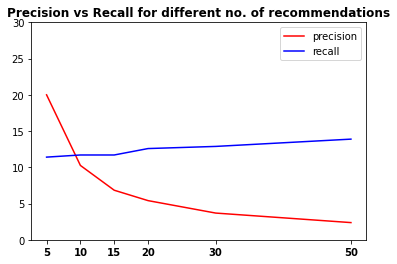

In [ ]:
random_eval = evaluation_methods()
rand_evaluation_df1, rand_evaluation_df1_5, rand_evaluation_df2 = random_eval.prec_recall_f1_computation(test, all_users_scores_1, users_list, True)

# POPULARITY-BASED RECOMMENDER

In [ ]:
class popularity_based:
  
  def popularity_computation(self, train):
    popular_songs_df = train.groupby(['title_artist'])[['rating']].count().sort_values('rating', ascending=False).reset_index()[:50]
    # display(popular_songs_df)

    users_list = list(train.user_id.unique())

    users_df = pd.DataFrame(users_list, columns=['user_id'])
    users_df['key'] = 1
    popular_songs_df['key'] = 1

    all_users_scores1 =  users_df.merge(popular_songs_df, on='key')  
    all_users_scores1.drop(columns = ['key','rating'], axis=1, inplace=True) 

    return all_users_scores1, users_list

In [ ]:
popularity_recommender = popularity_based()
all_users_scores_pop, users_list = popularity_recommender.popularity_computation(train)

# POPULARITY BASED EVALUATION

Evaluating for topk = 5 recommendations ....
 Evaluating for topk = 10 recommendations ....
 Evaluating for topk = 15 recommendations ....
 Evaluating for topk = 20 recommendations ....
 Evaluating for topk = 30 recommendations ....
 Evaluating for topk = 50 recommendations ....
 

,num_recommendations,precision@k,recall@k,f1-score@k
0,5,21.222222,11.288416,14.737654
1,10,12.820513,14.775414,13.728720
2,15,9.059829,15.661939,11.479316
3,20,7.323232,17.139480,10.261854
4,30,5.976431,20.981087,9.302935
5,50,4.101010,23.995272,7.004831


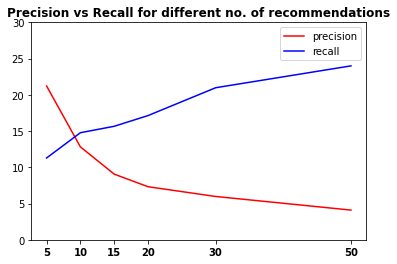

In [ ]:
popularity_eval = evaluation_methods()
pop_evaluation_df1, pop_evaluation_df1_5, pop_evaluation_df2 = popularity_eval.prec_recall_f1_computation(test, all_users_scores_pop, users_list, True)

# USER-BASED Collaborative Filtering

You try to find similar users that have a similar *rating pattern* to the selected user.

Different similarity measures:


*   Pearson correlation
*   Cosine Similarity
*   Jaccard Index/Dice similarity

Similarity measure used: Pearson correlation

<center>
$PC(u,u') = \frac{\Sigma_{i \in I}(r_{u,i} - \bar{r_u}) (r_{u',i} - \bar{r_{u'}})}{\sqrt{\Sigma_{i \in I} (r_{u,i} - \bar{r_u})^2} \sqrt{\Sigma_{i \in I} (r_{u',i} - \bar{r_{u'}})^2}}$

$r_{u,i}$ and $r_{u',i}$ are the rating scores for an item *i* given by two users *u* and *u*, 

$\bar{r_{u,i}}$ and $\bar{r_{u',i}}$ are the *average ratings* by the two users. 
</center>

The value of Pearson Correlation goes from 1, meaning perfect similarity, to -1, meaning perfect dissimilarity.







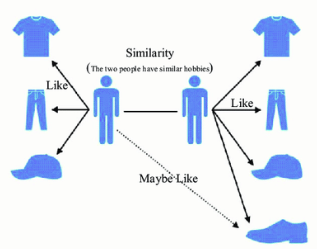


In [ ]:
class userbased_CF:
  
  def user_item_matrix_creation(self,train):
    #Create user-item matrix
    user_item_matrix = train.pivot_table(index='user_id', columns='title_artist', values='rating')
    user_item_matrix_filled = user_item_matrix.fillna(0)
    return user_item_matrix, user_item_matrix_filled
  
  def user_similarity_computation(self,user_item_matrix_filled):
    # User similarity matrix creation using Pearson correlation
    user_similarity = user_item_matrix_filled.T.corr(method='pearson')
    print("\n An example of the User-Items matrix after the Pearson Correlation computation:\n ")
    display(user_similarity.head())
    #GLI INDICI DELLA PIVOT_TABLE NON SONO NUMERI, MA I NOME DEGLI USER(string), quindi
    users_list = list(user_similarity)  
    return user_similarity, users_list 

  def usr_based_cf_computation(self,user_similarity,user_item_matrix):
    #Empty dataframe to store all the scores:
    all_users_scores = pd.DataFrame()
    test_df = pd.DataFrame()
    for picked_userid in users_list:
      # Get top n similar users
      similar_users = user_similarity[picked_userid].sort_values(ascending=False)[1:10]
      # Remove songs that have been listened to
      picked_userid_listened = user_item_matrix[user_item_matrix.index == picked_userid].dropna(axis=1, how='all')
      # Songs that similar users have listened to. Remove songs that none of the similar users have listened
      similar_user_songs = user_item_matrix[user_item_matrix.index.isin(similar_users.index)].dropna(axis=1, how='all')
      # Remove the listened song from the song list
      similar_user_songs.drop(picked_userid_listened.columns,axis=1, inplace=True, errors='ignore')
      

      # Recommend Items
      # A dictionary to store item scores
      item_score = {}
      for i in similar_user_songs.columns:
        song_rating = similar_user_songs[i]
        total = 0
        count = 0
        for u in similar_users.index:
          # If the song has rating
          if pd.isna(song_rating[u]) == False:
            # Score is the sum of user similarity score multiply by the song rating
            score = similar_users[u] * song_rating[u]
            # Add the score to the total score for the song
            total += score
            # Add 1 to the count
            count +=1
        # Average score for the item
        item_score[i] = total / count
        
      # Convert dictionary to pandas dataframe
      d = {'user_id': picked_userid, 'title_artist': item_score.keys(), 'score':item_score.values()}
      scores = pd.DataFrame(data=d)
      scores.sort_values(by='score', ascending= False, inplace=True)
      all_users_scores = pd.concat([all_users_scores, scores])
      
      # Predict items:
      # Average rating for the picked user
      avg_rating = user_item_matrix[user_item_matrix.index == picked_userid].T.mean()[picked_userid]
      
      # Calcuate the predicted rating
      all_users_scores['predicted_rating'] = all_users_scores['score'] + avg_rating
      all_users_scores['predicted_rating'] = all_users_scores['predicted_rating'].apply(lambda x: custom_round(x, base=.5))
      
      test_user = test[test.user_id == picked_userid]
      test_df = pd.concat([test_df,test_user])
      
         
      # Show the data
      temp_df1 = all_users_scores[['user_id','title_artist','predicted_rating']]
      temp_df2 = test_df[['user_id','title_artist','rating']]
      df_merge= pd.merge(temp_df1,temp_df2, on=['user_id', 'title_artist'],how='inner')
    # display(all_users_scores)
    print("\n\n An example of actual rating and computed predicted ratings for a user: \n")
    display(df_merge.head(10))
    print(df_merge.shape)

    return all_users_scores, df_merge

In [ ]:
user_based_cf = userbased_CF()
user_item_matrix, user_item_matrix_filled = user_based_cf.user_item_matrix_creation(train)
user_similarity, users_list = user_based_cf.user_similarity_computation(user_item_matrix_filled)
all_users_scores2, df_merge2 = user_based_cf.usr_based_cf_computation(user_similarity,user_item_matrix)


 An example of the User-Items matrix after the Pearson Correlation computation:
 


user_id,00b9144fc8cd453b81c362b30dbf8b8266eec220,0327a983748921d193b5073238b691353aeec66d,03b5ed94d78669559367806d44027ed4dd850070,0ab9d9f7925520801fffa8b63287d799cfe9a5a4,0c2932cb475b83b61039bdfbb72c14580b8fad2b,0e066a0791cd766df671fe7a6d37e7d9bf13f4a3,0f05851e8a215430d7be7ce4afc8b50fef5d305c,0f32755844786210adb20174574df58853d4a673,10d7dead6cfbb76453a9646d23bd2c1c9ba79044,113255a012b2affeab62607563d03fbdf31b08e7,...,edc19f85936d55d76b673d008bd2d220707af47a,ee30810179c611d32705fe0b71333dcb8703b30a,ef7d69342690c1b110267f1497b4d12bbcaca0cb,f1b274ebbbebde6f187b80ec79185530d20f7154,f44550a0969f977b2d46ff83fff4cb538308948f,f67a179bc047599216a7c69df93589aa298ac918,f71229a198e9475110eea9f3215b5f7e0ffe9083,fa5d9eddc010bc3fc71f8a42db15e5dd4f1c18a3,fd399da9b23b312054c75a57b82fe8b873abb3bf,fef771ab021c200187a419f5e55311390f850a50
user_id,,,,,,,,,,,,,,,,,,,,,
00b9144fc8cd453b81c362b30dbf8b8266eec220,1.000000,0.053769,-0.011340,-0.011581,-0.013205,-0.010280,0.045434,-0.012778,-0.012825,0.158193,...,-0.012199,-0.010284,-0.010309,0.123772,-0.010736,-0.010433,-0.012002,0.055785,-0.013709,-0.013760
0327a983748921d193b5073238b691353aeec66d,0.053769,1.000000,-0.011105,0.073394,-0.012931,0.031398,0.101832,-0.012514,-0.012560,0.124855,...,-0.011946,-0.010071,-0.010096,0.047967,-0.010514,-0.010217,-0.011754,-0.010633,-0.013425,0.025880
03b5ed94d78669559367806d44027ed4dd850070,-0.011340,-0.011105,1.000000,0.097504,-0.014122,-0.010995,-0.010896,0.034608,-0.013716,0.321140,...,-0.013047,-0.010998,-0.011026,-0.010427,0.046154,-0.011158,-0.012836,0.140403,0.060250,-0.014716
0ab9d9f7925520801fffa8b63287d799cfe9a5a4,-0.011581,0.073394,0.097504,1.000000,0.020278,-0.011228,0.062340,0.132800,0.043352,0.087369,...,0.040206,-0.011232,-0.011260,-0.010649,-0.011726,-0.011395,-0.013109,0.103674,0.022982,0.062549
0c2932cb475b83b61039bdfbb72c14580b8fad2b,-0.013205,-0.012931,-0.014122,0.020278,1.000000,0.089082,0.033100,-0.015913,-0.015972,-0.016655,...,0.014463,0.023998,0.035756,-0.012142,-0.013370,-0.012993,-0.014947,0.013908,0.014468,0.031214




 An example of actual rating and computed predicted ratings for a user: 



,user_id,title_artist,predicted_rating,rating
0,00b9144fc8cd453b81c362b30dbf8b8266eec220,Van Helsing Boombox - Man Man,1.5,3.5
1,00b9144fc8cd453b81c362b30dbf8b8266eec220,Guyamas Sonora - Beirut,1.5,1.5
2,00b9144fc8cd453b81c362b30dbf8b8266eec220,So Bored - Wavves,1.0,1.0
3,00b9144fc8cd453b81c362b30dbf8b8266eec220,The Legionnaire's Lament - The Decemberists,1.0,1.0
4,00b9144fc8cd453b81c362b30dbf8b8266eec220,Not Even Jail - Interpol,1.0,1.5
5,00b9144fc8cd453b81c362b30dbf8b8266eec220,Head Rolls Off - Frightened Rabbit,1.0,1.5
6,0327a983748921d193b5073238b691353aeec66d,Head Rolls Off - Frightened Rabbit,1.0,2.0
7,03b5ed94d78669559367806d44027ed4dd850070,Time Stands Still - Cut Copy,1.5,1.0
8,03b5ed94d78669559367806d44027ed4dd850070,All Eyes On Me - Girl Talk,1.5,1.0
9,03b5ed94d78669559367806d44027ed4dd850070,Patron [Explicit Album Version] - Yung Joc,1.0,1.5


(576, 4)


# USER-BASED CF EVALUATION


 RMSE value: 0.387522400786214

RATING TRESHOLD CHOSEN: 1
Evaluating for topk = 5 recommendations ....
 Evaluating for topk = 10 recommendations ....
 Evaluating for topk = 15 recommendations ....
 Evaluating for topk = 20 recommendations ....
 Evaluating for topk = 30 recommendations ....
 Evaluating for topk = 50 recommendations ....
 

,num_recommendations,precision@k,recall@k,f1-score@k
0,5,22.461538,12.943262,16.422947
1,10,14.696970,17.198582,15.849673
2,15,10.404040,18.262411,13.256113
3,20,8.080808,18.912530,11.323425
4,30,6.380471,22.399527,9.931866
5,50,4.686869,27.423168,8.005521


RATING TRESHOLD CHOSEN: 1.5
Evaluating for topk = 5 recommendations ....
 Evaluating for topk = 10 recommendations ....
 Evaluating for topk = 15 recommendations ....
 Evaluating for topk = 20 recommendations ....
 Evaluating for topk = 30 recommendations ....
 Evaluating for topk = 50 recommendations ....
 

,num_recommendations,precision@k,recall@k,f1-score@k
0,5,22.769231,13.120567,16.647919
1,10,14.893617,17.375887,16.039280
2,15,12.352122,20.981087,15.549715
3,20,9.506107,21.158392,13.118358
4,30,8.200544,24.940898,12.342790
5,50,7.342165,30.791962,11.857078


RATING TRESHOLD CHOSEN: 2
Evaluating for topk = 5 recommendations ....
 Evaluating for topk = 10 recommendations ....
 Evaluating for topk = 15 recommendations ....
 Evaluating for topk = 20 recommendations ....
 Evaluating for topk = 30 recommendations ....
 Evaluating for topk = 50 recommendations ....
 

,num_recommendations,precision@k,recall@k,f1-score@k
0,5,20.000000,6.560284,9.879840
1,10,16.666667,6.560284,9.414758
2,15,16.666667,6.560284,9.414758
3,20,16.666667,6.560284,9.414758
4,30,16.666667,6.560284,9.414758
5,50,16.666667,6.560284,9.414758


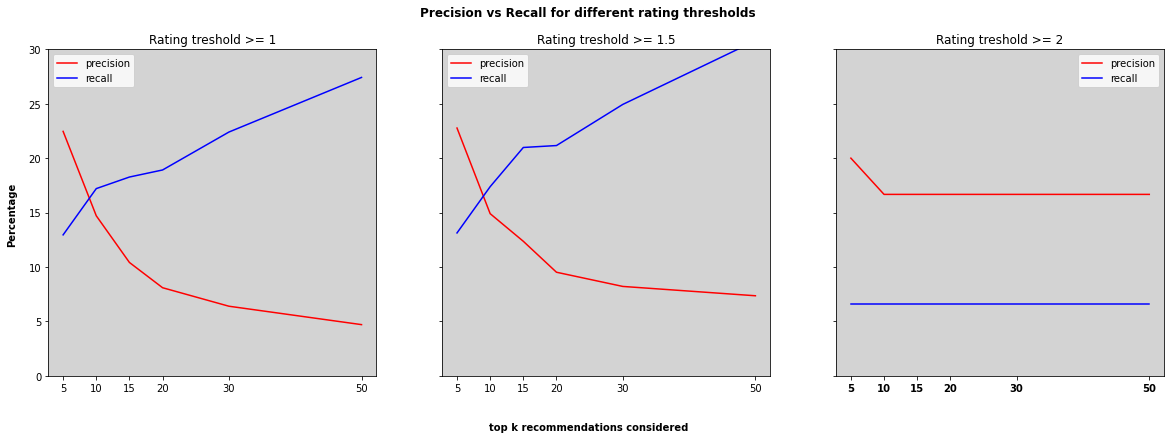

In [ ]:
evaluation_user_based_cf = evaluation_methods()
ub_rms = evaluation_user_based_cf.rmse_computation(df_merge2.rating, df_merge2.predicted_rating)
ub_evaluation_df1, ub_evaluation_df1_5, ub_evaluation_df2 = evaluation_user_based_cf.prec_recall_f1_computation(test, all_users_scores2, users_list, False)

# ITEM BASED Collaborative Filtering

The idea is to compute the similarities between items based on *co-ratings* by individual users.

- More stable and more meaningful recommendations. Due to the fact that *on average* there are usually more votes per item than votes per individual user 

Similarity measure used: Cosine similarity

<center>
$cos(u, u') = \frac{\Sigma_{i \in I} r_{u,i}r_{u',i}}{\sqrt{\Sigma_{i \in I}(r_{ui})^2 \sqrt{\Sigma_{i \in I} (r_{u'i})^2}}}$


 *I* represents the set of all items rated by both user *u* and *u'*,
 
 $r_{ui}$ and $r_{u'i}$ are the ratings for item *i* given by the two users
</center>

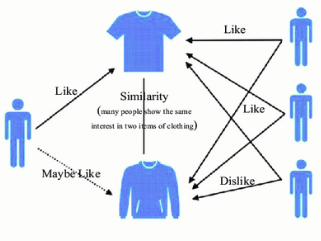

In [ ]:
class itembased_CF:

  def item_user_matrix_creation(self, train):
    #Create user-item matrix
    user_item_matrix = train.pivot_table(index='user_id', columns='title_artist', values='rating')
    item_user_matrix = train.pivot_table(index='title_artist', columns='user_id', values='rating')
    item_user_matrix_filled = item_user_matrix.fillna(0)
    # display(item_user_matrix_filled.head())
    return user_item_matrix, item_user_matrix, item_user_matrix_filled

  def item_similarity_computation(self, user_item_matrix, item_user_matrix, item_user_matrix_filled):
    item_similarity = cosine_similarity(item_user_matrix_filled)
    # display(item_similarity[:4])
    print(f'The item-item cosine similarity matrix has shape: {item_similarity.shape}')
    #GLI INDICI DELLA PIVOT_TABLE NON SONO NUMERI, MA I NOME DEGLI USER(string), quindi
    users_list = list(user_item_matrix.index)
    items_list = list(item_user_matrix.index)
    item_cos_similarity_df= pd.DataFrame(item_similarity, columns=items_list, index = items_list)
    # display(item_cos_similarity_df.head())
    return users_list, item_cos_similarity_df

  def item_based_cf_computation(self, users_list, item_user_matrix, item_cos_similarity_df):
    #Empty dataframe to store all the scores:
    all_users_scores = pd.DataFrame()
    test_df = pd.DataFrame()
    
    for picked_userid in users_list:
      all_similar_items_df = pd.DataFrame()
      #Seleziona le canzoni ascoltate dall'utente:
      picked_userid_listened = item_user_matrix[picked_userid].dropna(axis=0, how='all').to_frame(name= 'rating')
      already_listened = list(picked_userid_listened.index)
      # display(picked_userid_listened)
      # print(already_listened)

      
      # Get top n similar songs
      similar_items = pd.DataFrame()
      for song_listened in already_listened:
        sim_items = item_cos_similarity_df[song_listened].to_frame(name='similarity')
        a= sim_items.sort_values(by='similarity', ascending=False, inplace=False)
        a['score'] = sim_items['similarity']*picked_userid_listened.rating[song_listened] 
        similar_items = pd.concat([similar_items, a])
      
      # for song_listened in already_listened:
       
      similar_items = similar_items[~similar_items.index.isin(already_listened)]
      similar_items.reset_index(inplace=True)
      similar_items.rename(columns={'index':'title_artist'}, inplace=True)
      similar_items.drop_duplicates(subset =['title_artist'], keep='first', inplace=True)
      
      # TUTTE LE CANZONI SIMILI:
      all_similar_items_df = pd.concat([all_similar_items_df, similar_items])
      #Remove already listened songs from recommnedations:
      all_similar_items_df = all_similar_items_df[~all_similar_items_df.index.isin(already_listened)] 
            
      scores_sum = all_similar_items_df.groupby(all_similar_items_df.title_artist)['score'].sum().to_frame(name='score_sum').reset_index().rename(columns={'index':'title_artist'})  
      similarity_sum = all_similar_items_df.groupby(all_similar_items_df.title_artist)['similarity'].sum().to_frame(name='similarity_sum').reset_index().rename(columns={'index':'title_artist'})  
      
      temp_df = pd.merge(scores_sum, similarity_sum, on=['title_artist'],how='inner')
      temp_df['predicted_rating'] = temp_df.score_sum / temp_df.similarity_sum 

      d = {'user_id': picked_userid, 'title_artist': temp_df.title_artist, 'predicted_rating':temp_df.predicted_rating}
      temp_df_2 = pd.DataFrame(data=d)
      temp_df_2.sort_values(by='predicted_rating', ascending= False, inplace=True)
      all_users_scores = pd.concat([all_users_scores, temp_df_2])


      test_user = test[test.user_id == picked_userid]
      test_df = pd.concat([test_df,test_user])
            
        # Take a look at the data
    another_temp_df1 = all_users_scores[['user_id','title_artist', 'predicted_rating']]
    another_temp_df2 = test_df[['user_id', 'title_artist','rating']]
    df_merge = pd.merge(another_temp_df1, another_temp_df2, on=['user_id', 'title_artist'], how='inner')
    df_merge.dropna(inplace=True)
      
    print("\n\n An example of actual rating and computed predicted ratings for a user: \n")
    display(df_merge.head(10)) 
    return all_users_scores, df_merge 

In [ ]:
item_based_cf = itembased_CF()
user_item_matrix2, item_user_matrix2, item_user_matrix_filled = item_based_cf.item_user_matrix_creation(train)
users_list, item_cos_similarity_df = item_based_cf.item_similarity_computation(user_item_matrix2, item_user_matrix2, item_user_matrix_filled)
all_users_scores3, df_merge3 = item_based_cf.item_based_cf_computation(users_list, item_user_matrix2, item_cos_similarity_df)

The item-item cosine similarity matrix has shape: (1526, 1526)


 An example of actual rating and computed predicted ratings for a user: 



,user_id,title_artist,predicted_rating,rating
0,00b9144fc8cd453b81c362b30dbf8b8266eec220,Not Even Jail - Interpol,1.0,1.5
1,00b9144fc8cd453b81c362b30dbf8b8266eec220,Van Helsing Boombox - Man Man,1.0,3.5
2,00b9144fc8cd453b81c362b30dbf8b8266eec220,The Legionnaire's Lament - The Decemberists,1.0,1.0
3,00b9144fc8cd453b81c362b30dbf8b8266eec220,Head Rolls Off - Frightened Rabbit,1.0,1.5
4,00b9144fc8cd453b81c362b30dbf8b8266eec220,Guyamas Sonora - Beirut,1.0,1.5
7,0327a983748921d193b5073238b691353aeec66d,Curs in the Weeds - Horse Feathers,1.0,1.0
8,0327a983748921d193b5073238b691353aeec66d,Head Rolls Off - Frightened Rabbit,1.0,2.0
13,03b5ed94d78669559367806d44027ed4dd850070,Patron [Explicit Album Version] - Yung Joc,1.0,1.5
14,03b5ed94d78669559367806d44027ed4dd850070,Time Stands Still - Cut Copy,1.0,1.0
20,0ab9d9f7925520801fffa8b63287d799cfe9a5a4,Set You Free - Frightened Rabbit,1.0,1.0


# ITEM-BASED EVALUATION


 RMSE value: 0.5

RATING TRESHOLD CHOSEN: 1
Evaluating for topk = 5 recommendations ....
 Evaluating for topk = 10 recommendations ....
 Evaluating for topk = 15 recommendations ....
 Evaluating for topk = 20 recommendations ....
 Evaluating for topk = 30 recommendations ....
 Evaluating for topk = 50 recommendations ....
 

,num_recommendations,precision@k,recall@k,f1-score@k
0,5,23.368421,13.120567,16.805450
1,10,12.263158,13.770686,12.973274
2,15,10.119250,17.553191,12.837692
3,20,6.810036,15.721040,9.503394
4,30,4.862543,16.725768,7.534611
5,50,3.704110,19.976359,6.249422


RATING TRESHOLD CHOSEN: 1.5
Evaluating for topk = 5 recommendations ....
 Evaluating for topk = 10 recommendations ....
 Evaluating for topk = 15 recommendations ....
 Evaluating for topk = 20 recommendations ....
 Evaluating for topk = 30 recommendations ....
 Evaluating for topk = 50 recommendations ....
 

,num_recommendations,precision@k,recall@k,f1-score@k
0,5,25.894737,14.539007,18.622256
1,10,12.947368,14.539007,13.697105
2,15,9.144852,15.484634,11.498793
3,20,6.439791,14.539007,8.925980
4,30,4.537522,15.366430,7.006198
5,50,3.033258,16.548463,5.126797


RATING TRESHOLD CHOSEN: 2
Evaluating for topk = 5 recommendations ....
 Evaluating for topk = 10 recommendations ....
 Evaluating for topk = 15 recommendations ....
 Evaluating for topk = 20 recommendations ....
 Evaluating for topk = 30 recommendations ....
 Evaluating for topk = 50 recommendations ....
 

,num_recommendations,precision@k,recall@k,f1-score@k
0,5,0.000000,0.000000,0.000000
1,10,10.000000,9.278960,9.625996
2,15,12.356688,17.198582,14.381023
3,20,5.668790,10.520095,7.367550
4,30,3.779193,10.520095,5.560762
5,50,2.553853,13.593381,4.299869


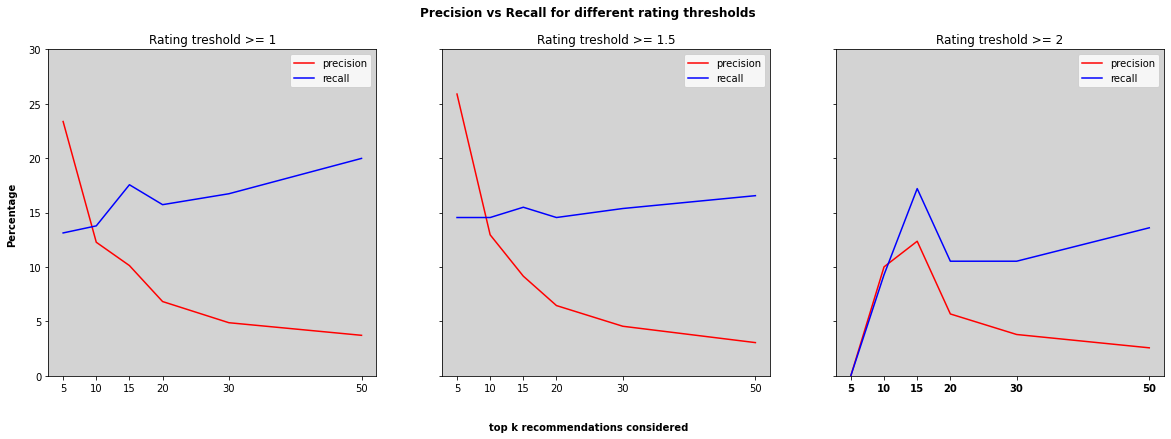

In [ ]:
evaluation_item_based_cf = evaluation_methods()
ib_rms = evaluation_item_based_cf.rmse_computation(df_merge3.rating, df_merge3.predicted_rating)
ib_evaluation_df1, ib_evaluation_df1_5, ib_evaluation_df2 = evaluation_item_based_cf.prec_recall_f1_computation(test, all_users_scores3, users_list, False)

# TRUNCATED SVD

Model-based algorithm useful to reduce the original dimension of the User-Item matrix retrieving hidden latent features useful for the recommendation

Matrix decomposition of a User-Item matrix *A*  with *truncated SVD*, where we take *k* largest singular values ($0<k<r$ (with *r* rank of A), thus "truncated"):

<center>
$SVD(A) = U \times \Sigma \times V^T$

U and V are two ortogonal matrices with dimension *m* x *m* and *n* x *n*

$Σ$ is the *singular matrix*, quadratic matrix having dimension *k* x *k*

<br/>

 *(disregard the image below where matrix $Σ$ is not square*
 
 *Image is just an example, operation is the same*)  

</center>


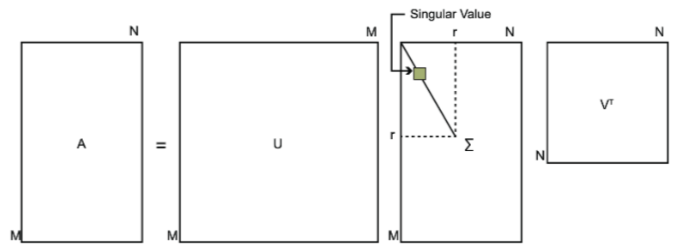

In [ ]:
class SVD_RS:
  
  def create_user_item_matrix(self, train): 
    #Creating a sparse pivot table with users in rows and items in columns
    user_items_matrix = train.pivot_table(index='user_id', columns='title_artist', values='rating')
    user_items_matrix_filled = user_items_matrix.fillna(0)
    return user_items_matrix, user_items_matrix_filled

  def SVD_computation(self, user_items_matrix_filled):
    #The number of factors to factorize the user-item matrix:
    NUMBER_OF_FACTORS_MF = 15
    #Performs matrix factorization of the original User-Items matrix:
    U, sigma, Vt = svds(user_items_matrix_filled, k = NUMBER_OF_FACTORS_MF)

    print(f"U shape: {U.shape}")
    print(f"V shape: {Vt.shape}")
    sigma = np.diag(sigma)
    print(f"sigma shape: {sigma.shape}")

    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
    #Normalize:
    all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())
    return all_user_predicted_ratings_norm

  def compute_recommendations(self, user_items_matrix, user_items_matrix_filled, all_user_predicted_ratings_norm):
    users_list = list(user_items_matrix_filled.index)
    # user_items_matrix.droplevel(1, axis=1).set_index('user_id')
    scores_df = pd.DataFrame(all_user_predicted_ratings_norm, index=user_items_matrix_filled.index, columns=user_items_matrix_filled.columns)
    # display(scores_df.head(10))

    all_users_scores = pd.DataFrame()

    for picked_userid in users_list:
      
      temp_dict = {'user_id':None, 'title_artist':[]}

      #Save all the songs the user has previously listened to, to eliminate them from the recommendations: 
      picked_userid_listened = user_items_matrix[user_items_matrix.index == picked_userid].dropna(axis=1, how='all').T#.to_frame(name= 'rating')
      already_listened = list(picked_userid_listened.index)
      

      similar_items = scores_df[scores_df.index==picked_userid].T
      similar_items.rename(columns={picked_userid:'score'}, inplace=True)
      similar_items.sort_values(by='score', ascending=False, inplace=True)
      
      
      predictions = similar_items[~similar_items.index.isin(already_listened)][:50]


      temp_dict['user_id'] = picked_userid
      for song in predictions.index:
        temp_dict['title_artist'].append(song)

      temp = pd.DataFrame(data=temp_dict)
      all_users_scores = pd.concat([all_users_scores, temp])

    #display(all_users_scores.head())
    return all_users_scores, users_list


In [ ]:
svd_recommender = SVD_RS()
user_items_matrix, user_items_matrix_filled = svd_recommender.create_user_item_matrix(train)
all_user_predicted_ratings_norm = svd_recommender.SVD_computation(user_items_matrix_filled)
all_users_scores4, users_list = svd_recommender.compute_recommendations(user_items_matrix, user_items_matrix_filled, all_user_predicted_ratings_norm)

U shape: (198, 15)
V shape: (15, 1526)
sigma shape: (15, 15)


Evaluating for topk = 5 recommendations ....
 Evaluating for topk = 10 recommendations ....
 Evaluating for topk = 15 recommendations ....
 Evaluating for topk = 20 recommendations ....
 Evaluating for topk = 30 recommendations ....
 Evaluating for topk = 50 recommendations ....
 

,num_recommendations,precision@k,recall@k,f1-score@k
0,5,26.262626,15.366430,19.388516
1,10,17.222222,20.153664,18.572985
2,15,12.929293,22.695035,16.473616
3,20,10.202020,23.877069,14.295824
4,30,7.626263,26.773050,11.871069
5,50,5.111111,29.905437,8.730159


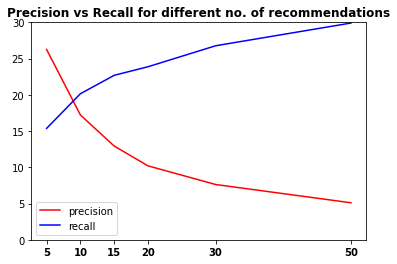

In [ ]:
svd_eval = evaluation_methods()
svd_evaluation_df1, svd_evaluation_df1_5, svd_evaluation_df2 = svd_eval.prec_recall_f1_computation(test, all_users_scores4, users_list, True)

# CONTENT-BASED RECOMMENDER

Recommendations computed relying on the **features** associated with the compared items

A **user profile** is created based on the features of the object rated in the past by the user

*Scores matrix* *S* is computed following:
<center>
$UserFeatures = X \times F\ \ $   ($m \times k$)     
 
*X* is the User-Item matrix $\ \ (m \times n$)

*F* is the Item-Features matrix $\ \ (n \times k$)

<br/>
$Scores = UserFeatures \times UserFeatures^T \ \ $   ($m \times m$) 

</center>

From scores matrix that has dimensions ($m \times m$), compute the Euclidean distance between each pair of users. 

<center>
Euclidean_distance = $\sqrt{\sum\limits_{i=1}^N (p_i - q_i)^2}$
</center>

Select the most similar to the active user and make recommendations.

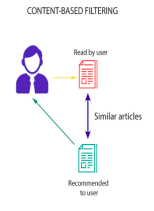

In [ ]:
class content_based_RS:

  def create_feature_matrix(self, train):
    temporary_df1 = train.copy()[['user_id','title_artist','rating','genre']]
    # All songs with a rating <= 1.5 will have a value of -1, all ratings >1.5 will have 1 as value:  
    temporary_df1.loc[(temporary_df1.rating <=1.5), 'rating']=-1
    temporary_df1.loc[(temporary_df1.rating >1.5), 'rating']=1
    temporary_df1.sort_values(by='user_id', inplace=True)
    # display(temporary_df1)

    # Get a list of all features and create a BINARY dataframe where each song has 1 and 0 for its relative musical genre: 
    tag_df = temporary_df1[['title_artist','genre']]
    tag_df.drop_duplicates(subset=['title_artist'], inplace=True)
    genres = tag_df['genre']
    features_list = list(set(genres ))
    # display(tag_df)

    for col in features_list:
        tag_df[col] = tag_df["genre"].apply(lambda x: 1 if col in x else 0)

    #Creation of item-features dataframe:
    tag_df.drop(columns=['genre'], inplace=True)
    tag_df.set_index('title_artist', inplace=True)
    tag_df.sort_values(by='title_artist', inplace=True)
    features = tag_df.values
    return features, temporary_df1

  def create_user_item_matrix(self, temporary_df1):
    #Create user-item matrix:
    user_item_matrix = temporary_df1.pivot_table(index='user_id', columns='title_artist', values='rating')
    #Fill NaN values with 0 to make all the further computations:
    user_item_matrix_filled = user_item_matrix.fillna(0)
    return user_item_matrix, user_item_matrix_filled
    
  def content_based_computation(self, user_item_matrix_filled, features):
    #Dot product between user-item matrix and item-features matrix to obtain the USER-FEATURES matrix:
    user_features = np.dot(user_item_matrix_filled, features)
    #Dot product between user-features matrix obtained before and the TRANSPOSE item-features matrix to have the FINAL USER-ITEM matrix to make the recommendations:  
    scores = np.dot(user_features, features.T)
    #Transform USER-ITEM matrix in a dataframe to make further computations easier:
    scores_df = pd.DataFrame(data=scores, columns=user_item_matrix.columns, index=user_item_matrix.index)
    print("---- Start fitting ----")
    # display(scores_df)
    

    #List of all users on which iterate to compute recommendations for every user:
    users_list = list(user_item_matrix_filled.index)

    #After having the complete USER-ITEM matrix, compute the euclidean distance between each pair of users and store the results inside a dataframe:  
    euclidean_dist_users = pd.DataFrame(squareform(pdist(scores_df)), columns = scores_df.index, index = scores_df.index)
    #Show user's similarity with an heatmap to have a better view: 
    plt.figure(figsize=(10,10))
    print("---- End fitting ----")
    print("\nUsers' similarity heatmap:")
    sns.heatmap(euclidean_dist_users, cmap='OrRd', linewidth=1)

    # pairwise = pd.DataFrame(squareform(pdist(scores_df)), columns = scores_df.index, index = scores_df.index)

    # Until now you have a MxM matrix (made by all euclidean distances between all users), we have to move to long form to consider USERS and ITEMS (songs)
    long_form = euclidean_dist_users.unstack()

    # rename columns and turn into a dataframe
    long_form.index.rename(['first_user', 'second_user'], inplace=True)
    long_form = long_form.to_frame('euclidean_distance').reset_index()
    # display(long_form)
    # Delete all rows with NaN or 0 value:
    long_form.dropna(axis=0, inplace=True)
    long_form.drop(long_form[(long_form.euclidean_distance==0) & (long_form.euclidean_distance==0.0)].index, inplace=True)
    

    #Empty dataframe to store all the final recommendations to evaluate for every user 
    all_users_scores = pd.DataFrame()


    for picked_userid in users_list:
      
      #Temporary dictionary to create the dataframe that will store the user_id and the relative recommendations for that user
      temp_dict = {'user_id':None, 'title_artist':[]}

      #Save all the songs the user has previously listened to, to eliminate them from the recommendations: 
      picked_userid_listened = user_item_matrix[user_item_matrix.index == picked_userid].dropna(axis=1, how='all').T#.to_frame(name= 'rating')
      already_listened = list(picked_userid_listened.index)

      #Sort all the users based on their minimal euclidean distance from the picked_userid and choose as similar_user(from which you will take the recommendations) the most similar one  
      df = long_form[long_form.first_user==picked_userid]
      df.sort_values(by='euclidean_distance', ascending=True, inplace=True)
      similar_user = df['second_user'].iloc[0]
      
      #Find similar songs to that the user has listened to and recommend them:
      similar_items = user_item_matrix[user_item_matrix.index == similar_user].T.rename(columns={similar_user:'value'})#dropna(axis=1, how='all').T
      similar_items.sort_values(by='value', ascending=False, inplace=True)
      #Remove already listened songs from recommendations:
      predictions = similar_items[~similar_items.index.isin(already_listened)]
      predictions = predictions[:50]

      #Create the final dataframe with all users and their relative recommendations:
      temp_dict['user_id'] = picked_userid
      for song in predictions.index:
        temp_dict['title_artist'].append(song)

      temp = pd.DataFrame(data=temp_dict)
      all_users_scores = pd.concat([all_users_scores, temp])
    # display(all_users_scores)
    
    return all_users_scores, users_list




---- Start fitting ----
---- End fitting ----

Users' similarity heatmap:


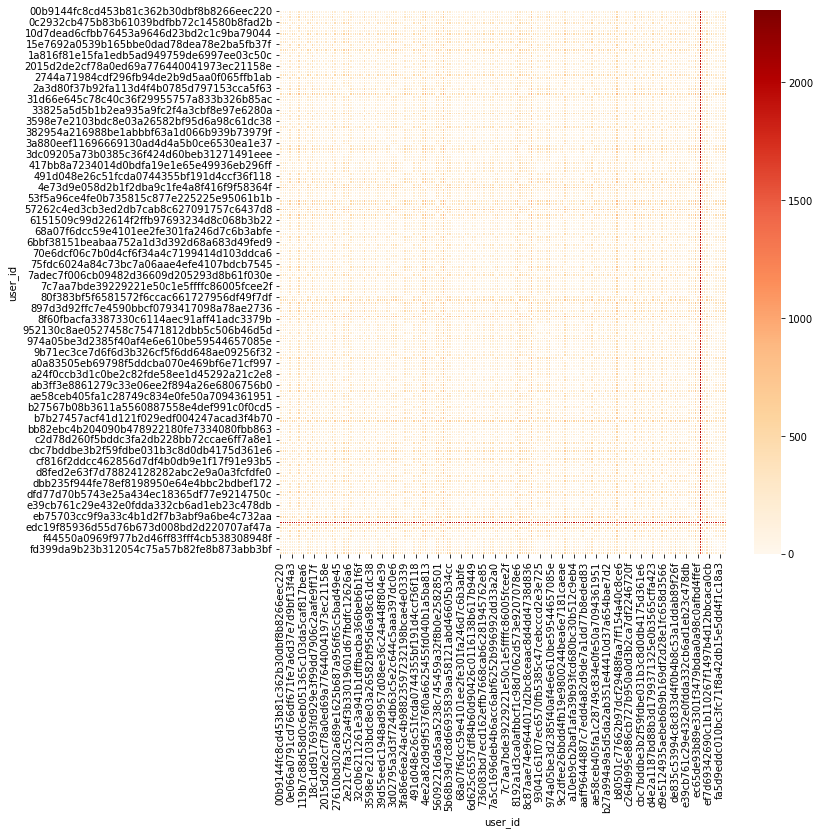

In [ ]:
content_based = content_based_RS()
tag_df, temporary_df1 = content_based.create_feature_matrix(train)
user_item_matrix5, user_item_matrix_filled = content_based.create_user_item_matrix(temporary_df1)
all_users_scores5, users_list = content_based.content_based_computation(user_item_matrix_filled, tag_df)

# CONTENT-BASED EVALUATION

Evaluating for topk = 5 recommendations ....
 Evaluating for topk = 10 recommendations ....
 Evaluating for topk = 15 recommendations ....
 Evaluating for topk = 20 recommendations ....
 Evaluating for topk = 30 recommendations ....
 Evaluating for topk = 50 recommendations ....
 

,num_recommendations,precision@k,recall@k,f1-score@k
0,5,28.247423,16.193853,20.586026
1,10,19.595960,22.931442,21.132898
2,15,13.198653,23.167849,16.816817
3,20,9.974747,23.345154,13.977353
4,30,6.397306,22.458629,9.958071
5,50,3.353535,19.621749,5.728088


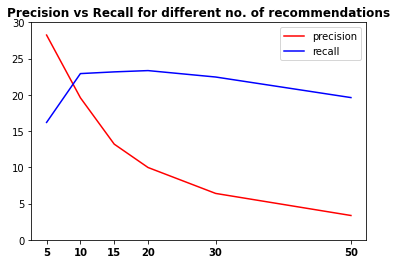

In [ ]:
evaluation_content_based = evaluation_methods()
cb_evaluation_df1, cb_evaluation_df1_5, cb_evaluation_df2 = evaluation_content_based.prec_recall_f1_computation(test, all_users_scores5, users_list, True)

# OVERALL EVALUATION OF ALL IMPLEMENTED METHODS

In [ ]:
def complete_evaluation_precision(rand_evaluation_df1, pop_evaluation_df1, ub_evaluation_df1_5, ib_evaluation_df1_5, cb_evaluation_df1):
  rand_prec = rand_evaluation_df1[['num_recommendations', 'precision@k']]
  rand_prec['recommender_method'] = "Random"

  pop_prec = pop_evaluation_df1[['num_recommendations', 'precision@k']]
  pop_prec['recommender_method'] = "Popular"

  userbased_prec = ub_evaluation_df1[['num_recommendations', 'precision@k']]
  userbased_prec['recommender_method'] = "User-based CF"

  itembased_prec = ib_evaluation_df1[['num_recommendations', 'precision@k']]
  itembased_prec['recommender_method'] = "Item-based CF"

  contentbased_prec = cb_evaluation_df1[['num_recommendations', 'precision@k']]
  contentbased_prec['recommender_method'] = "Content based"

  svd_prec = svd_evaluation_df1[['num_recommendations', 'precision@k']]
  svd_prec['recommender_method'] = "SVD"
  complete_evaluation_df = pd.concat([rand_prec, pop_prec, userbased_prec, itembased_prec, svd_prec, contentbased_prec])
  # display(complete_evaluation_df)


  hover = alt.selection(
    type="single", on="mouseover", fields=["recommender_method"], nearest=True
  )

  # line plot
  lineplot = alt.Chart(complete_evaluation_df).mark_line().encode(
    x="num_recommendations:N",
    y="precision@k:Q",
    color="recommender_method:N",
  ).properties(
    height=500, width=1000).properties(title='RECOMMENDATIONS PRECISION@k')
  # nearest point
  point = lineplot.mark_circle().encode(
    opacity=alt.value(10)
  ).add_selection(hover)
  # highlight
  singleline = lineplot.mark_line().encode(
    size=alt.condition(~hover, alt.value(0.9), alt.value(4))
  )

  display(point + singleline)


def complete_evaluation_recall(rand_evaluation_df1, pop_evaluation_df1, ub_evaluation_df1_5, ib_evaluation_df1_5, cb_evaluation_df1):
  rand_rec = rand_evaluation_df1[['num_recommendations', 'recall@k']]
  rand_rec['recommender_method'] = "Random"

  pop_rec = pop_evaluation_df1[['num_recommendations', 'recall@k']]
  pop_rec['recommender_method'] = "Popular"

  userbased_rec = ub_evaluation_df1_5[['num_recommendations', 'recall@k']]
  userbased_rec['recommender_method'] = "User-based CF"

  itembased_rec = ib_evaluation_df1_5[['num_recommendations', 'recall@k']]
  itembased_rec['recommender_method'] = "Item-based CF"

  contentbased_rec = cb_evaluation_df1[['num_recommendations', 'recall@k']]
  contentbased_rec['recommender_method'] = "Content based"

  svd_rec = svd_evaluation_df1[['num_recommendations', 'recall@k']]
  svd_rec['recommender_method'] = "SVD"
  complete_evaluation_df = pd.concat([rand_rec, pop_rec, userbased_rec, itembased_rec, svd_rec, contentbased_rec])

  hover = alt.selection(
   type="single", on="mouseover", fields=["recommender_method"], nearest=True)

  # line plot
  lineplot = alt.Chart(complete_evaluation_df).mark_line().encode(
    x="num_recommendations:N",
    y="recall@k:Q",
    color="recommender_method:N",
  ).properties(
    height=500, width=1000).properties(title='RECOMMENDATIONS RECALL@k')
  # nearest point
  point = lineplot.mark_circle().encode(
    opacity=alt.value(10)
  ).add_selection(hover)
  # highlight
  singleline = lineplot.mark_line().encode(
    size=alt.condition(~hover, alt.value(0.9), alt.value(4))
  )

  display(point + singleline)


def complete_evaluation_f1_score(rand_evaluation_df1, pop_evaluation_df1, ub_evaluation_df1_5, ib_evaluation_df1_5, cb_evaluation_df1):
  rand_f1 = rand_evaluation_df1[['num_recommendations', 'f1-score@k']]
  rand_f1['recommender_method'] = "Random"

  pop_f1 = pop_evaluation_df1[['num_recommendations', 'f1-score@k']]
  pop_f1['recommender_method'] = "Popular"

  userbased_f1 = ub_evaluation_df1[['num_recommendations', 'f1-score@k']]
  userbased_f1['recommender_method'] = "User-based CF"

  itembased_f1 = ib_evaluation_df1[['num_recommendations', 'f1-score@k']]
  itembased_f1['recommender_method'] = "Item-based CF"

  contentbased_f1 = cb_evaluation_df1[['num_recommendations', 'f1-score@k']]
  contentbased_f1['recommender_method'] = "Content based"

  svd_f1 = svd_evaluation_df1[['num_recommendations', 'f1-score@k']]
  svd_f1['recommender_method'] = "SVD"
  complete_evaluation_df = pd.concat([rand_f1, pop_f1, userbased_f1, itembased_f1, svd_f1, contentbased_f1])


  hover = alt.selection(
    type="single", on="mouseover", fields=["recommender_method"], nearest=True
  )

  # line plot
  lineplot = alt.Chart(complete_evaluation_df).mark_line().encode(
    x="num_recommendations:N",
    y="f1-score@k:Q",
    color="recommender_method:N",
  ).properties(
    height=500, width=1000).properties(title='RECOMMENDATIONS F1-SCORE@k')
  # nearest point
  point = lineplot.mark_circle().encode(
    opacity=alt.value(10)
  ).add_selection(hover)
  # highlight
  singleline = lineplot.mark_line().encode(
    size=alt.condition(~hover, alt.value(0.9), alt.value(4))
  )

  display(point + singleline)


# OVERALL EVALUATION OF ALL IMPLEMENTED METHODS - GRAPHS

As already known in literature, the **Content-based** method has the best performance in terms of recommendation precision, followed by the  **SVD**, the **Item-based CF** and the **User-based CF**. Obviously the **Popularity-based** and the **Random-based** recommenders have the worst performance.

In [ ]:
complete_evaluation_precision(rand_evaluation_df1, pop_evaluation_df1, ub_evaluation_df1_5, ib_evaluation_df1_5, cb_evaluation_df1)
complete_evaluation_recall(rand_evaluation_df1, pop_evaluation_df1, ub_evaluation_df1_5, ib_evaluation_df1_5, cb_evaluation_df1)
complete_evaluation_f1_score(rand_evaluation_df1, pop_evaluation_df1, ub_evaluation_df1_5, ib_evaluation_df1_5, cb_evaluation_df1)

alt.LayerChart(...)

alt.LayerChart(...)

alt.LayerChart(...)